In [78]:
import instaseis
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import obspy
from obspy.imaging.beachball import beach,beachball
from obspy.taup import TauPyModel
%matplotlib inline

### Initialize an instaseis database

In [79]:
db = instaseis.open_db("./databases/20s_PREM_ANI_FORCES")
print db

ReciprocalInstaseisDB reciprocal Green's function Database (v7) generated with these parameters:
	components           : vertical and horizontal
	velocity model       : prem_ani
	attenuation          : True
	dominant period      : 20.000 s
	dump type            : displ_only
	excitation type      : dipole
	time step            : 4.869 s
	sampling rate        : 0.205 Hz
	number of samples    : 370
	seismogram length    : 1796.8 s
	source time function : errorf
	source shift         : 34.085 s
	spatial order        : 4
	min/max radius       : 5700.0 - 6371.0 km
	Planet radius        : 6371.0 km
	min/max distance     : 0.0 - 180.0 deg
	time stepping scheme : newmark2
	compiler/user        : gfortran 4.9.1 by lion on dhcp-10-181-12-69.dynamic.eduroam.mwn.de
	directory/url        : databases/20s_PREM_ANI_FORCES
	size of netCDF files : 598.2 MB
	generated by AxiSEM version 60945ec at 2014-10-23T15:35:34.000000Z



### Windowing function

In [80]:
prem = TauPyModel('prem')
def window_stream(stream,source,receiver,phase,t_start,t_end,taup_model):
    phase_arrs = taup_model.get_travel_times_geo(source_depth_in_km=source.depth_in_m/1000.0, 
                                                 source_latitude_in_deg=source.latitude,
                                                 source_longitude_in_deg=source.longitude, 
                                                 receiver_latitude_in_deg=receiver.latitude,
                                                 receiver_longitude_in_deg=receiver.longitude,
                                                 phase_list=[phase])
    arr = phase_arrs[0]
    st_new = obspy.Stream()
    for tr in stream:
        starttime = tr.stats.starttime + arr.time + t_start
        endtime = tr.stats.starttime + arr.time + t_end
        windowed_tr = tr.slice(starttime=starttime,endtime=endtime)
        st_new += windowed_tr
        
    #return st_new.resample(1.0)
    return st_new
    

### Sample moment tensor inversion with a single station (using synthetic data)

In this example, we will invert for earthquake source parameters (and uncertainties) using a test event with a known moment tensor solution. We will invert for the point source MT solution of the 2011 Virginia event, recorded at station US.AAM in Ann Arbor, MI. We will first perform the inversion using synthetic waveforms from the 'known' MT solution.

[ 3.9900e+16 -8.0500e+16  1.2300e+17 -3.0000e+15 -4.7019e+17  8.1000e+14]
-2999999999999962.0 810000000000013.4 3809999999999975.5


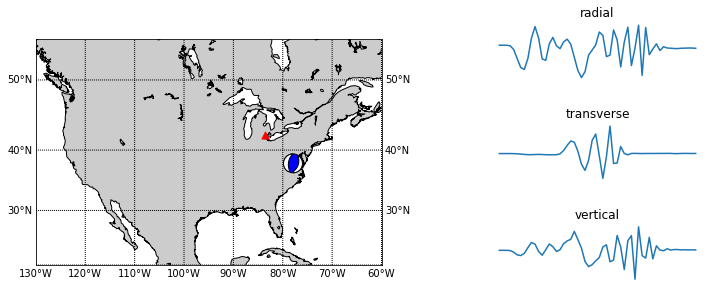

In [81]:
#define 'true' source parameters
m_rr_true = 4.710000e+24
m_tt_true = 3.810000e+22
m_pp_true = -4.740000e+24
m_rt_true = 3.990000e+23
m_rp_true = -8.050000e+23
m_tp_true = -1.230000e+24
lon_true = -77.93
lat_true = 37.91
depth_true = 12000.
mt_true = [m_rr_true,m_tt_true,m_pp_true,
           m_rt_true,m_rp_true,m_tp_true]
an_true = [m_rt_true,
           m_rp_true,
           -m_tp_true,
           m_rr_true + m_pp_true,
           m_tt_true + m_pp_true,
           m_rr_true+m_tt_true+m_pp_true]
an_true = np.array(an_true)/1E7
print an_true
print an_true[3], an_true[5], -an_true[3]+an_true[5]

#get seismograms
rec_lon = -83.66
rec_lat = 42.3 
receiver = instaseis.Receiver(
    latitude=rec_lat, longitude=rec_lon, network="US", station="AAM")
source_true = instaseis.Source(
    latitude=lat_true, longitude=lon_true, depth_in_m=depth_true,
    m_rr = m_rr_true / 1E7,
    m_tt = m_tt_true / 1E7,
    m_pp = m_pp_true / 1E7,
    m_rt = m_rt_true / 1E7,
    m_rp = m_rp_true / 1E7,
    m_tp = m_tp_true / 1E7,
    origin_time=obspy.UTCDateTime(2011, 8, 23, 17, 51, 3))
st = db.get_seismograms(source=source_true, receiver=receiver,components='RTZ',kind='displacement')

#window seismograms
st_true = window_stream(stream=st,source=source_true,
                        receiver=receiver,phase='P',
                        t_start=-20.0,t_end=250.0,
                        taup_model=prem)


#plot map and 'true' (synthetic) data
fig=plt.figure()
ax=fig.add_axes([0.1,0.1,0.8,0.8])
# setup mercator map projection.
m = Basemap(llcrnrlon=-130.,llcrnrlat=20.,urcrnrlon=-60.,urcrnrlat=55.,\
            resolution='l',projection='merc',\
            lat_0=40.,lon_0=-20.,lat_ts=20.)
m.drawcoastlines()
m.fillcontinents()
m.drawparallels(np.arange(10,90,10),labels=[1,1,0,1])
m.drawmeridians(np.arange(-180,180,10),labels=[1,1,0,1])
x, y = m(lon_true, lat_true)
#ax = plt.gca()
b = beach(mt_true, xy=(x, y), width=400000, linewidth=1, alpha=1.0)
b.set_zorder(10)
ax.add_collection(b)
x, y = m(rec_lon, rec_lat)
ax.scatter(x,y,marker='^',color='r',s=50,zorder=99)

#plot_waveforms
#radial
ax_r=fig.add_axes([1.15,0.75,0.5,0.2])
ax_r.plot(st_true[0].data)
ax_r.set_title('radial')
ax_r.set_axis_off()
ax_t=fig.add_axes([1.15,0.4,0.5,0.2])
ax_t.plot(st_true[1].data)
ax_t.set_title('transverse')
ax_t.set_axis_off()
ax_z=fig.add_axes([1.15,0.05,0.5,0.2])
ax_z.plot(st_true[2].data)
ax_z.set_title('vertical')
ax_z.set_axis_off()
plt.show()

### Model parameterization
As in Mustac and Tkalcic (2016), we parameterize the MT solution $\mathbf{M}$ as a sum of six elementary moment tensors. Additionally,
there are 3 location parameters, lon, lat, and depth. The origin time is assumed to be known exactly.

$
\mathbf{M^1} = \begin{matrix} 
               0 & 1 & 0 \\
               1 & 0 & 0 \\
               0 & 0 & 0 
               \end{matrix}
$
$\hspace{1cm}$
$
\mathbf{M^2} = \begin{matrix} 
               0 & 0 & 1 \\
               0 & 0 & 0 \\
               1 & 0 & 0 
               \end{matrix}
$
$\hspace{1cm}$
$
\mathbf{M^3} = \begin{matrix} 
               0 & 0 & 0 \\
               0 & 0 & -1 \\
               0 & -1 & 0 
               \end{matrix}
$ 

$
\mathbf{M^4} = \begin{matrix} 
               -1 & 0 & 0 \\
               0 & 0 & 0 \\
               0 & 0 & 1 
               \end{matrix}
$
$\hspace{1cm}$
$
\mathbf{M^5} = \begin{matrix} 
               0 & 0 & 0 \\
               0 & -1 & 0 \\
               0 & 0 & 1 
               \end{matrix}
$
$\hspace{1cm}$
$
\mathbf{M^6} = \begin{matrix} 
               1 & 0 & 0 \\
               0 & 1 & 0 \\
               0 & 0 & 1 
               \end{matrix}
$ 

The full moment tensor can be expressed as a linear combination of each of these elementary moment tensors

$\mathbf{M} = \sum_{n=1}^6 a_n \mathbf{M}^n$

where $a_n$ is the weighting factor.

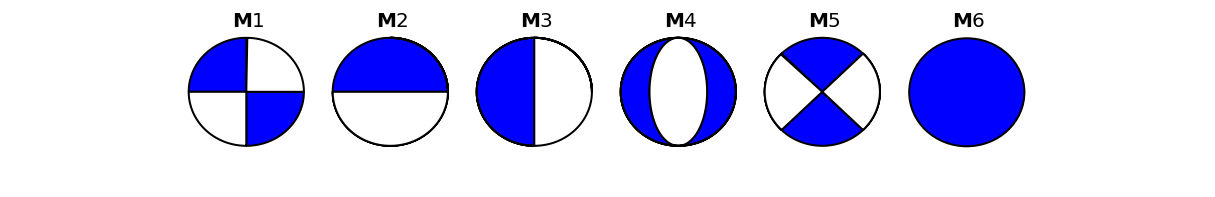

In [82]:
fig = plt.figure(figsize=(16,2.25))
ax = fig.add_axes([0.0,0.0,1.0,1.0])
ax.set_xlim(-0.25,1.75)
ax.set_ylim((-0.05,0.25))

m_elem_list = []
m_1 = [0,0,0,0,0,1]
m_2 = [0,0,0,1,0,0]
m_3 = [0,0,0,0,1,0]
m_4 = [-1,0,1,0,0,0]
m_5 = [0,1,-1,0,0,0]
m_6 = [1,1,1,0,0,0]
m_elem_list = [m_1,m_2,m_3,m_4,m_5,m_6]

for ii,m_elem in enumerate(m_elem_list):
    bb = beach(m_elem,xy=(0.1+ii*0.25, 0.1),width=0.2)
    ax.add_collection(bb)
    ax.text(0.075+ii*0.25,0.22,'$\mathbf{M}$'+str(ii+1),fontsize=20)
ax.set_axis_off()
plt.show()

#Note! obspy beachball is not trustworthy... M5 is clearly incorrect.

### Bayesian inversion

The Bayes mantra is 'the posterior is proportional to the likelyhood times the prior'... i.e., 

$p(\mathbf{m}|\mathbf{d}) \propto p(\mathbf{d}|\mathbf{m}) p(\mathbf{m})$

We will assume a uniform prior.

### Forward model

The forward problem is to generate three component (RTZ) synthetic seismograms for a given proposed moment tensor, and location parameters. The synthetic data must be processed in the same manner as the 'true' data. In our case this means windowing the data around the P arrival.

In [83]:
def forward_model(model_vec, receiver):
    '''
    model_vec:
        model_vec[0] = a_1
        model_vec[1] = a_2
        model_vec[2] = a_3
        model_vec[3] = a_4
        model_vec[4] = a_5
        model_vec[5] = a_6
        model_vec[6] = source longitude
        model_vec[7] = source latitude
        model_vec[8] = source depth (m)
    
    receiver:
        instaseis receiver object
    '''
    source = instaseis.Source(
    #latitude=model_vec[7], longitude=model_vec[6], depth_in_m=model_vec[8],
    latitude=lat_true,longitude=lon_true,depth_in_m=depth_true,
    m_rr = -1.0*model_vec[3] + model_vec[5],
    m_tt = -1.0*model_vec[4] + model_vec[5],
    m_pp = model_vec[3]+model_vec[4]+model_vec[5],
    m_rt = model_vec[0],
    m_rp = model_vec[1],
    m_tp = -1.0*model_vec[2],
    origin_time=obspy.UTCDateTime(2011, 8, 23, 17, 51, 3))
    st_model = db.get_seismograms(source=source, receiver=receiver,components='RTZ',kind='displacement')
    st_model_windowed = window_stream(stream=st_model,source=source,
                               receiver=receiver,phase='P',
                               t_start=-20.0,t_end=250.0,
                               taup_model=prem)
    #print model_vec
    #print source
    return st_model_windowed
    

### Misfit function

In [84]:
def chi2(st_true,st_model,sigma=1e-6):
    data_vector = np.hstack((st_true[0].data,st_true[1].data,st_true[2].data))
    predicted_data_vector = np.hstack((st_model[0].data,st_model[1].data,st_model[2].data))
    chi2_misfit = np.linalg.norm((data_vector - predicted_data_vector)/sigma)**2
    #print 'CHI2',chi2_misfit
    return chi2_misfit

### Likelihood function 

In [85]:
#def likelihood(st_true,st_model):
#    chi2_misfit = chi2(st_true,st_model)
#    p_dm = np.exp(-0.5*chi2_misfit)
#    return p_dm

def likelihood(st_true,st_model,sigma=1e-4):
    data_vector = np.hstack((st_true[0].data,st_true[1].data,st_true[2].data))
    predicted_data_vector = np.hstack((st_model[0].data,st_model[1].data,st_model[2].data))
    misfit = np.linalg.norm(predicted_data_vector-data_vector)
    pdm = np.exp(-0.5*(misfit/sigma)**2)
    return pdm
    

### Markov chain

We will perform a sample markov chain, with a 'burn in' period of 100 iterations

In [86]:
chain = []
burn_in = 10000
iter_max = 100000

#initialize a 'random' guess for the moment tensor. For a first test, the location parameters will be correct
lon_test = lon_true
lat_test = lat_true
depth_test = depth_true
model_current = [(np.random.rand()-0.5)*1E16,
                 (np.random.rand()-0.5)*1E16,
                 (np.random.rand()-0.5)*1E16,
                 (np.random.rand()-0.5)*1E16,
                 (np.random.rand()-0.5)*1E16,
                 (np.random.rand()-0.5)*1E16]#,
                 #lon_test,
                 #lat_test,
                 #depth_test]
            
#TEST WITH SOMETHING CLOSE TO REAL SOLUTION
#model_current = [4E16,-8E16,-1.2E17,-4.7E17,-3.5E15,2.7E14]
            
st_current = forward_model(model_current,receiver)
likelihood_current = likelihood(st_true,st_current)

for i in range(0,iter_max):
    #model_proposed = [model + 0.1*(np.random.rand()-0.5) for model in model_current]
    #model_proposed = [model + 1.0e16*(np.random.rand()-0.5) for model in model_current]
    model_proposed = [model + 1.0e15*(np.random.rand()-0.5) for model in model_current]
    st_proposed = forward_model(model_proposed, receiver)
    likelihood_proposed = likelihood(st_true,st_proposed)
    #print likelihood_proposed, likelihood_current
    #ratio = np.exp(likelihood_proposed - likelihood_current)
    r = np.random.rand()
    #print 'i {}:'.format(i),likelihood_proposed,r
    if likelihood_proposed > r:
        model_current = model_proposed
        likelihood_current = likelihood_proposed
    if i > burn_in and i%50. == 0:
        chain.append(model_current)
        print i
        
print 'DONE'

1020
1040
1060
1080
1100
1120
1140
1160
1180
1200
1220
1240
1260
1280
1300
1320
1340
1360
1380
1400
1420
1440
1460
1480
1500
1520
1540
1560
1580
1600
1620
1640
1660
1680
1700
1720
1740
1760
1780
1800
1820
1840
1860
1880
1900
1920
1940
1960
1980
2000
2020
2040
2060
2080
2100
2120
2140
2160
2180
2200
2220
2240
2260
2280
2300
2320
2340
2360
2380
2400
2420
2440
2460
2480
2500
2520
2540
2560
2580
2600
2620
2640
2660
2680
2700
2720
2740
2760
2780
2800
2820
2840
2860
2880
2900
2920
2940
2960
2980
3000
3020
3040
3060
3080
3100
3120
3140
3160
3180
3200
3220
3240
3260
3280
3300
3320
3340
3360
3380
3400
3420
3440
3460
3480
3500
3520
3540
3560
3580
3600
3620
3640
3660
3680
3700
3720
3740
3760
3780
3800
3820
3840
3860
3880
3900
3920
3940
3960
3980
4000
4020
4040
4060
4080
4100
4120
4140
4160
4180
4200
4220
4240
4260
4280
4300
4320
4340
4360
4380
4400
4420
4440
4460
4480
4500
4520
4540
4560
4580
4600
4620
4640
4660
4680
4700
4720
4740
4760
4780
4800
4820
4840
4860
4880
4900
4920
4940
4960
4980
5000


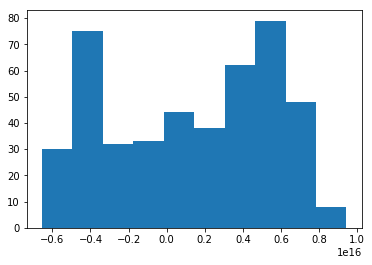

In [96]:
m_1_chain = []
m_2_chain = []
m_3_chain = []
m_4_chain = []
m_5_chain = []
m_6_chain = []
for i in range(0,len(chain)):
    m_1_chain.append(chain[i][0])
    m_2_chain.append(chain[i][1])
    m_3_chain.append(chain[i][2])
    m_4_chain.append(chain[i][3])
    m_5_chain.append(chain[i][4])
    m_6_chain.append(chain[i][5])
plt.hist(m_1_chain)
plt.show()

In [88]:
model_avg = np.average(chain,axis=0)
print model_avg

[ 1.32869395e+15 -4.16540357e+14  2.06317501e+16  7.66542206e+14
  1.26116060e+16 -8.67348338e+15]


In [89]:
map_1 = 1e17
map_2 = 0.9e18
map_3 = 0.5e18 #0.8e18
map_4 = 1.0e18
map_5 = 4.0e17
map_6 = 0.75e17
MAP = [map_1,map_2,map_3,map_4,map_5,map_6]

In [90]:
st_best = forward_model(model_avg,receiver)
st_best = forward_model()
plt.plot(st_true[2].data)
plt.plot(st_best[2].data)
plt.show()

TypeError: forward_model() takes exactly 2 arguments (0 given)

In [ ]:
st = forward_model(an_true,receiver)
plt.plot(st[0].data)
plt.plot(st_true[0].data)
plt.show()

### Check that the proper moment tensor is being used in the forward problem

In [ ]:
'''
model_vec:
        model_vec[0] = a_1
        model_vec[1] = a_2
        model_vec[2] = a_3
        model_vec[3] = a_4
        model_vec[4] = a_5
        model_vec[5] = a_6
'''
MT_true = np.zeros((3,3))
MT_true[0,0] = m_rr_true/1E7
MT_true[1,1] = m_tt_true/1E7
MT_true[2,2] = m_pp_true/1E7
MT_true[1,0] = MT_true[0,1] = m_rt_true/1E7
MT_true[2,0] = MT_true[0,2] = m_rp_true/1E7
MT_true[1,2] = MT_true[2,1] = m_tp_true/1E7
print MT_true
print '\n'

test_vec = np.zeros(6)
test_vec[0] = m_rt_true/1E7
test_vec[1] = m_rp_true/1E7
test_vec[2] = m_tp_true/1E7
test_vec[3] = -4.707E17
test_vec[4] = -3.54E15
test_vec[5] = 2.7E14
print test_vec
print '\n'

def reconstruct_MT(model_vec):
    MT = np.zeros((3,3))
    MT[0,0] = -model_vec[3] + model_vec[5]
    MT[1,0] = MT[0,1] = model_vec[0]
    MT[2,0] = MT[0,2] = model_vec[1]
    MT[2,1] = MT[1,2] = model_vec[2]
    MT[0,0] = -model_vec[3] + model_vec[5]
    MT[1,1] = -model_vec[4] + model_vec[5]
    MT[2,2] = model_vec[3] + model_vec[4] + model_vec[5]
    print MT
reconstruct_MT(test_vec)

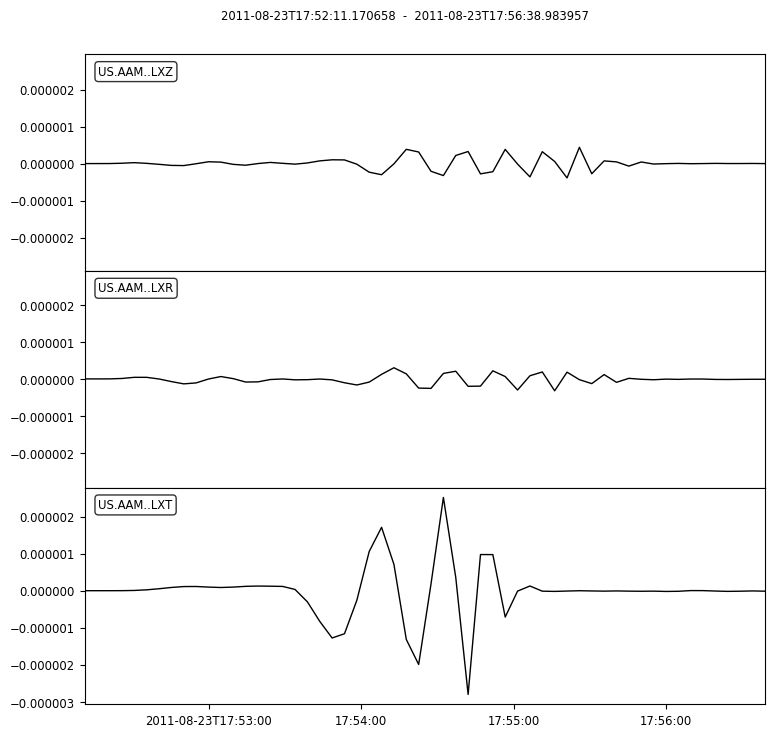

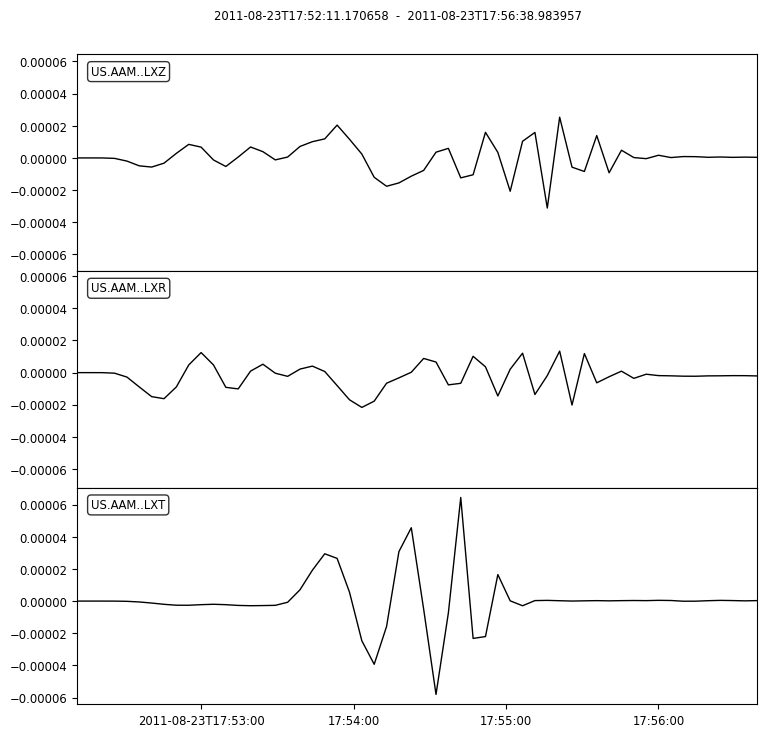

In [97]:
st_current.plot()
st_true.plot()